<p align="center">
<a href="https://github.com/jina-ai/dalle"><img src="https://github.com/jina-ai/dalle-flow/blob/main/.github/banner.svg?raw=true" alt="DALL·E Flow: A Human-in-the-Loop workflow for creating HD images from text" width="60%"></a>
<br>
</p>


<b>A Human-in-the-Loop<sup><a href="https://en.wikipedia.org/wiki/Human-in-the-loop">?</a></sup> workflow for creating HD images from text</b>

[![GitHub Repo stars](https://img.shields.io/github/stars/jina-ai/dalle-flow?style=social)](https://github.com/jina-ai/dalle-flow) [![Google Colab](https://img.shields.io/badge/Slack-2.8k-blueviolet?logo=slack&amp;logoColor=white&style=flat-square)](https://slack.jina.ai) [![GitHub last commit (branch)](https://img.shields.io/github/last-commit/jina-ai/dalle-flow/main)](https://colab.research.google.com/github/jina-ai/dalle-flow/blob/main/client.ipynb)



🚧 If you find your request fails, it is possible the server is occasionally down for maintaince. Please give it a try in 5 minutes.

- **2022/6/3** Reduce default number of images to 2 per pathway, 4 for diffusion.
- ⚠️ 2022/5/23 Fix an upstream bug in CLIP-as-service. This bug makes the 2nd diffusion step irrelevant to the given texts. New Dockerfile proved to be reproducible on a AWS EC2 `p2.x8large` instance.
- 2022/5/13b Removing TLS as Cloudflare gives 100s timeout, making DALLE Flow in usable [Please _reopen_ the notebook in Google Colab!](https://colab.research.google.com/github/jina-ai/dalle-flow/blob/main/client.ipynb).
- 🔐 2022/5/13 New Mega checkpoint! All connections are now with TLS, [Please _reopen_ the notebook in Google Colab!](https://colab.research.google.com/github/jina-ai/dalle-flow/blob/main/client.ipynb).
- 🌟 2022/5/10 [A Dockerfile is added! Now you can easily deploy your own DALL·E Flow](https://github.com/jina-ai/dalle-flow). New Mega checkpoint! Smaller memory-footprint, the whole Flow can now fit into **one GPU with 21GB memory**.
- 🌟 2022/5/9 Less memory-footprint overall, the whole Flow can now fit into one GPU with 18GB memory!
- 🌟 2022/5/7 DALL·E Flow just got updated!
    - New DALL·E Mega checkpoint
    - Improved GLID3 memory-efficiency and parameters
- 🌟 2022/5/6 DALL·E Flow just got updated!
    - The first step will generate 16 candidates: **8 from DALL·E Mega, 8 from GLID3-XL**; ranked by CLIP-as-service.
    - Optimized the flow efficiency, diffusion and upscaling is much faster now!
- ~~⚠️ 2022/5/3 **The number of images is restrict to 9 for DALL·E Mega, and 16 for GLID3-XL**~~
- ⚠️ 2022/5/2 **Due to the massive requests now, the server is super busy.** You can deploy your own server by following [the instruction here](https://github.com/jina-ai/dalle-flow#server).


Using client is super easy. The following steps are best run in Jupyter notebook or [Google Colab](https://colab.research.google.com/github/jina-ai/dalle-flow/blob/main/client.ipynb).  

The only dependency you will need are [DocArray](https://github.com/jina-ai/docarray) and [Jina](https://github.com/jina-ai/jina), as DocArray is already included in Jina you only need to install `jina`.

> On Google Colab, you will be asked to restart the kernel. Go ahead and restart.

In [1]:
!pip install jina

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We have provided a demo server for you to play:

In [2]:
server_url = 'grpc://dalle-flow.jina.ai:51005'

### Step 1: Generate via DALL·E Mega

Now let's define the prompt:

In [3]:
prompt = 'a surfer in the game Grand theft auto five'

Let's submit it to the server and visualize the results:

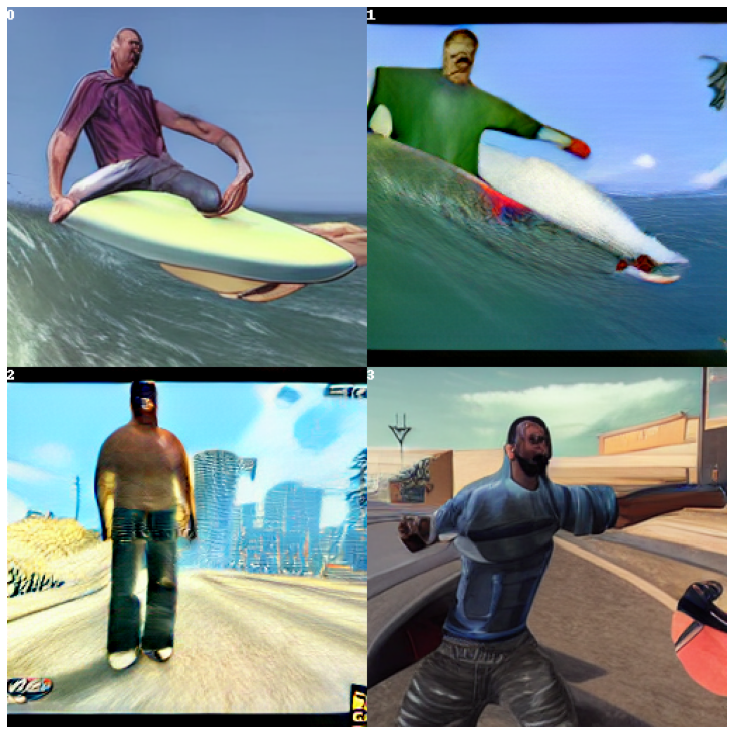

CPU times: user 3.02 s, sys: 388 ms, total: 3.41 s
Wall time: 6min 11s


In [4]:
%%time

from docarray import Document

da = Document(text=prompt).post(server_url, parameters={'num_images': 2}).matches

da.plot_image_sprites(fig_size=(10,10), show_index=True)

Here we generate 4 candidates, 2 from DALLE-mega and 2 from GLID3 XL, this is as defined in `num_images`, which takes about ~2 minutes. You can use a smaller value if it is too long for you. The results are sorted by [CLIP-as-service](https://github.com/jina-ai/clip-as-service), with index-`0` as the best candidate judged by CLIP. 

### Step 2: Select and refinement via GLID3 XL

Of course, you may think differently. Notice the number in the top-left corner? Select the one you like the most and get a better view:

In [5]:
fav_id = 3

fav = da[fav_id]

fav.display()

Now let's submit the selected candidates to the server for diffusion.

In [ ]:
%%time

diffused = fav.post(f'{server_url}', parameters={'skip_rate': 0.6, 'num_images': 4}, target_executor='diffusion').matches

diffused.plot_image_sprites(fig_size=(10,10), show_index=True)

This will give 4 images based on the given image. You may allow the model to improvise more by giving `skip_rate` a near-zero value, or a near-one value to force its closeness to the given image. The whole procedure takes about ~1 minutes.


### Step 3: Select and upscale via SwinIR

Select the image you like the most, and give it a closer look:


In [ ]:
dfav_id = 2

fav = diffused[dfav_id]

fav.display()

Finally, submit to the server for the last step: upscaling to 1024 x 1024px.

> This step should be much faster (~10s) as the Flow is designed in unblocked manner.

In [ ]:
%%time

fav = fav.post(f'{server_url}/upscale')
fav.display()

> 💁‍♂️ On Google colab this image may render exactly the same size as before. But it is in 1024x1024 already. Right click on the image and copy/save it. You will see.

That's it! It is _the one_. If not satisfied, please repeat the procedure. Btw, DocArray is a powerful and easy-to-use data structure for unstructured data. It is super productive for data scientists who work in cross-/multi-modal domain. To learn more about DocArray, [please check out the docs](https://docarray.jina.ai).